**Importing Necessary Libraries**




In [1]:
import pandas as pd
import os
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pycaret as py


**Data Loading and Attack Classification Functions**



In [2]:
#function merge all the files in a folder
def fileReader(fz):
    fd =[]

    for root,dir,files in os.walk(fz):
        for file in files:
            
            t= pd.read_csv(os.path.join(root,file)).iloc[:,:32]
            t['file_source'] =re.split(r"\.pcap",file)[0]
            fd.append(t)      
        
    fg = pd.concat(fd) 
 
    return fg
# function to filter the attack type
def attack(f):
    if re.split(r'-',f)[0]:
        return re.split('-',f)[0]
def attack_status(f):
    if re.search('benign',f,re.I):
        return "Normal"
    else :
        return "Attack"
        

**Loading and Merging IoMT Traffic Data**

In [3]:
test = fileReader(r'F:\CICIoMT2024\WiFI_and_MQTT\attacks\csv\test')
train = fileReader(r'F:\CICIoMT2024\WiFI_and_MQTT\attacks\csv\train')
data = pd.concat([test,train])
data['attack_type']=data['file_source'].apply(attack)
data['traffic']=data['attack_type'].str.split(r'_(test|train)').apply(lambda x: x[0])
data['traffic_status'] = data['traffic'].apply(attack_status)


**Visualizing Traffic Type Distribution**



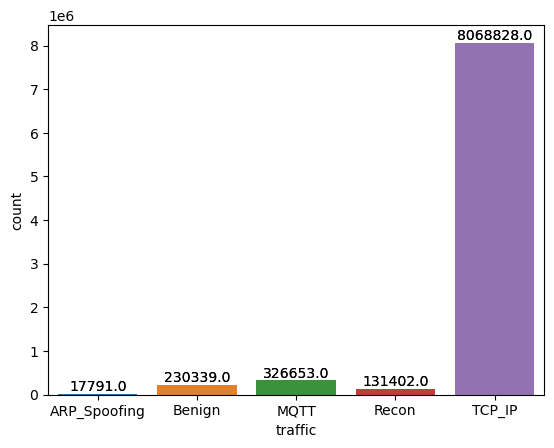

In [4]:
sns.countplot(x=data['traffic'])
ax=sns.countplot(x=data['traffic'])
for i in ax.patches:
    ax.annotate(f'{i.get_height()}',(i.get_x()+i.get_width()/2,i.get_height()),ha='center',va='center',
               xytext=(0,5),textcoords='offset points')

plt.show()    

**Visualizing Traffic Status (Normal vs. Attack) Distribution**



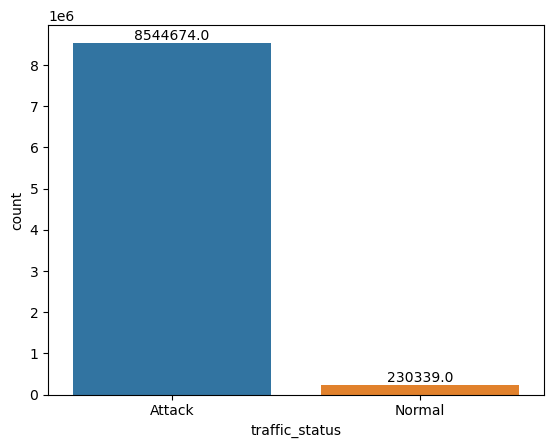

In [6]:
ax=sns.countplot(x=data['traffic_status'])
for i in ax.patches:
    ax.annotate(f'{i.get_height()}',(i.get_x()+i.get_width()/2,i.get_height()),ha='center',va='center',
               xytext=(0,5),textcoords='offset points')
plt.show()

**Filtering Relevant Features for Machine Learning**

In [7]:
# filtering columns to be used for ML
mlData= data.filter(['Header_Length','Protocol Type','Duration','Rate','Srate','Drate','HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP',
       'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC','traffic_status'])


In [8]:
col1_num = [c for c in mlData.columns if data[c].dtypes !='O']
col_ob =[c for c in mlData.columns if data[c].dtypes =='O']

In [16]:
X=mlData[col1_num]
Y =mlData[col_ob]

**Data Preprocessing: Scaling and Encoding Features**

In [10]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
#ct = make_column_transformer((MinMaxScaler(),col1_num),(LabelEncoder(),col_ob),remainder='passthrough')
#mlData1 = ct.fit_transform(mlData)
ct1 =make_column_transformer((MinMaxScaler(),col1_num),remainder = 'passthrough')
X=ct1.fit_transform(X)
lb = LabelEncoder()
Y = lb.fit_transform(Y)


**Splitting the Dataset for Training and Testing**

In [11]:
from sklearn.model_selection import train_test_split,cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

**Importing Machine Learning Models and Performance Metrics**

In [12]:
from sklearn.linear_model import LogisticRegressionCV,SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer


**Evaluating Multiple Machine Learning Models Using Cross-Validation**

In [13]:
result = {}
ty = [LogisticRegressionCV( random_state = 42),LinearSVC( random_state = 42),DecisionTreeClassifier( random_state = 42),RandomForestClassifier( random_state = 42),
      GradientBoostingClassifier( random_state = 42),SGDClassifier( random_state = 42)]
for i in ty:
    
    result[str(i).split('(')[0]] = cross_val_score(i,X_train,y_train,cv =5)
result

{'LogisticRegressionCV': array([0.98350779, 0.9837103 , 0.98352678, 0.98364059, 0.98425446]),
 'LinearSVC': array([0.98334325, 0.98360272, 0.98336223, 0.98363426, 0.9840203 ]),
 'DecisionTreeClassifier': array([0.99053248, 0.9911337 , 0.99070968, 0.99111466, 0.99129186]),
 'RandomForestClassifier': array([0.99389927, 0.99398787, 0.99407647, 0.99404479, 0.99419035]),
 'GradientBoostingClassifier': array([0.99077297, 0.9909565 , 0.99132988, 0.99148171, 0.99144374]),
 'SGDClassifier': array([0.98140671, 0.98172314, 0.98193831, 0.98179264, 0.9823369 ])}

**Data Preparation**

In [17]:
yData= data.filter(['Header_Length','Protocol Type','Duration','Rate','Srate','Drate','HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP',
       'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC','traffic_status'])
yData['traffic_status'] = yData['traffic_status'].apply(lambda x: 0 if x == 'Attack' else 1)

# Load additional traffic log dataset#
con = pd.read_csv(r'F:\combined_traffic_log.csv')
con['traffic_status'] = con['Traffic_Type'].apply(lambda x: 1 if x == 'Normal' else 0)
#Merge Dataset#
mlData=pd.concat([yData,con])

# Defining columns for numerical features and the target#

col1_num = ['Header_Length','Protocol Type','Duration','Rate','Srate','Drate','HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP',
       'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC']
col_ob =['traffic_status']

In [18]:
from sklearn.compose import make_column_transformer
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,StandardScaler,Normalizer
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegressionCV,SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score

**Data Preprocessing and Train-Test Split**



In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
#ct = make_column_transformer((MinMaxScaler(),col1_num),(LabelEncoder(),col_ob),remainder='passthrough')
#mlData1 = ct.fit_transform(mlData)
ct1 =make_column_transformer((Normalizer(),col1_num),remainder = 'drop')
X_train=ct1.fit_transform(X_train)
X_test =ct1.fit_transform(X_test)
lb = LabelEncoder()
Y_train = lb.fit_transform(y_train)
Y_test = lb.fit_transform(y_test)

param = {'num_leaves':32 , 'objective': 'binary','verbose':-1,'path_smooth' : 2,'max_bin': 25}
param['metric'] = ['auc', 'binary_logloss']


In [20]:
lighttrain = lgb.Dataset(X_train,Y_train)

lighttest = lgb.Dataset(X_test,Y_test,reference=lighttrain)

In [21]:
model = lgb.train(param,lighttrain,valid_sets=lighttest,num_boost_round=5000,callbacks=[lgb.early_stopping(stopping_rounds=5)])

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[32]	valid_0's auc: 0.997642	valid_0's binary_logloss: 0.0184709


In [22]:
y_predict_train = model.predict(X_train)
y_predict_test =model.predict(X_test)

In [23]:
p = [y_predict_train,y_predict_test]
for i in p:
    for t in range(len(i)):
        if i[t] >= 0.6:
            i[t] = 1
        else:
            i[t]=0
            

**Model Evaluation and Confusion Matrix**

0.9907979462611457
0.8710442069276839
              precision    recall  f1-score   support

           0       0.99      1.00      1.00   1708831
           1       0.89      0.74      0.81     46212

    accuracy                           0.99   1755043
   macro avg       0.94      0.87      0.90   1755043
weighted avg       0.99      0.99      0.99   1755043



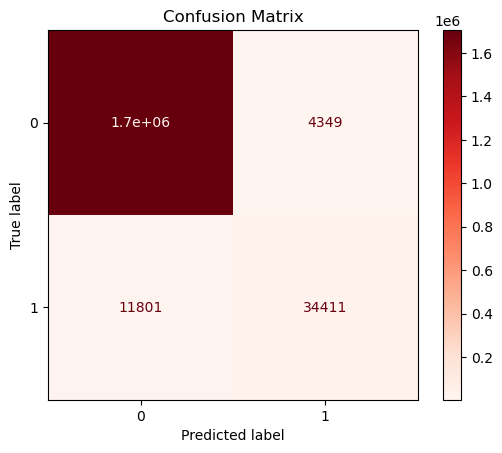

In [24]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, ConfusionMatrixDisplay

# Print accuracy and ROC AUC score
print(accuracy_score(y_test, y_predict_test))
print(roc_auc_score(y_test, y_predict_test))

# Print classification report
print(classification_report(y_test, y_predict_test))

# Plot and print the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_predict_test, cmap='Reds')
plt.title('Confusion Matrix')
plt.show()

In [31]:
test['attack_type']=test['file_source'].apply(attack)
test['traffic']=test['attack_type'].str.split(r'_(test|train)').apply(lambda x: x[0])
test['traffic_status'] = test['traffic'].apply(attack_status)
# filtering columns to be used for ML
mlData1= test.filter(['Header_Length','Protocol Type','Duration','Rate','Srate','Drate','HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP',
       'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC','traffic_status'])
mlData1['traffic_status'] = mlData1['traffic_status'].apply(lambda x: 0 if x == 'Attack' else 1)
test1 = mlData1.filter(col1_num)
test11=ct1.fit_transform(test1)
y11 = lb.fit_transform(mlData1['traffic_status'])
mlData1['predict']=model.predict(test11)

In [32]:
new_data = pd.read_csv(r"C:\Users\Habeeb\Downloads\combined_traffic_log_1million.csv")
new_data["traffic_status"] = new_data["Traffic_Type"].apply(lambda x : 1 if x=="Normal" else 0)
new_data.drop(columns=["Traffic_Type"],inplace=True )
newX = ct1.fit_transform(new_data.drop(columns=['traffic_status']))

In [33]:
new_data['predict']= model.predict(newX)
new_data['predict'] =new_data['predict'].apply(lambda x: 1 if x> 0.6 else 0)

0.914639
0.914639
              precision    recall  f1-score   support

           0       0.85      1.00      0.92    500000
           1       1.00      0.83      0.91    500000

    accuracy                           0.91   1000000
   macro avg       0.93      0.91      0.91   1000000
weighted avg       0.93      0.91      0.91   1000000



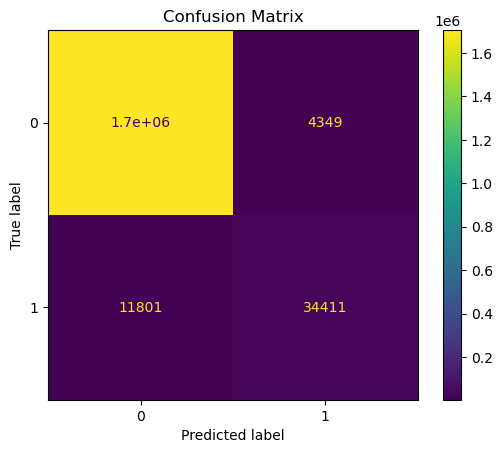

In [34]:
print(accuracy_score(new_data['traffic_status'],new_data['predict'])) 
print(roc_auc_score(new_data['traffic_status'],new_data['predict']))
print(classification_report(new_data['traffic_status'],new_data['predict']))

ConfusionMatrixDisplay.from_predictions(y_test, y_predict_test, cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

In [35]:
#y1_predict_test =lm.predict(test1)
#y1_predict_test
mlData1['predict'] =model.predict(test11)
mlData1['predict'] = mlData1['predict'].apply(lambda x: 1 if x>=0.6 else 0)

0.9911546529449591
0.8536454704911184
              precision    recall  f1-score   support

           0       0.99      1.00      1.00   1576575
           1       0.89      0.71      0.79     37607

    accuracy                           0.99   1614182
   macro avg       0.94      0.85      0.89   1614182
weighted avg       0.99      0.99      0.99   1614182



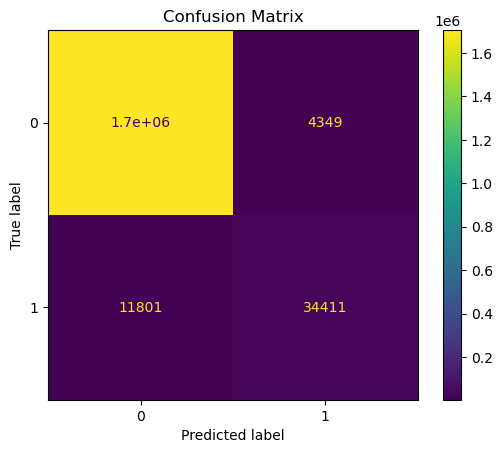

In [36]:
print(accuracy_score(mlData1['traffic_status'],mlData1['predict']))
print(roc_auc_score(mlData1['traffic_status'],mlData1['predict']))
from sklearn.metrics import classification_report
print(classification_report(mlData1['traffic_status'],mlData1['predict']))

ConfusionMatrixDisplay.from_predictions(y_test, y_predict_test, cmap='viridis')
plt.title('Confusion Matrix')
plt.show()